# Домашнее задание №4

In [45]:
#!pip install prettytable

In [80]:
from Bio import SeqIO
import numpy as np
from prettytable import PrettyTable
import random
import matplotlib.pyplot as plt

## Задача №1 (1)
В папке data лежат два файла islands.fasta и nonIslands.fasta. В них хранятся прочтения из CpG островков и из обычных участков генома соответственно, этими данными нужно будет воспользоваться в первом задании.
Определите частоты генерации для каждого из нуклеотидов внутри CpG островков и вне их. Посчитайте так-же частоты для всех упорядоченных пар нуклеотидов и сравните частоту пары CG внутри островков и снаружи. Сделайте вывод. 

In [2]:
def cnt_freq(file):
    """
    Вычисляю частоты 2-мя способами:
    1. как среднюю частоту среди всех последовательностей (мне кажется этот вариант более показательным)
    2. частота по всем последовательностям
    В примере последовательности имеют равную длину, поэтому результаты совпали.
    Возвращаю оба варианта
    """
    nucl1, nucls = np.zeros(4), []
    pair1, pairs = np.zeros((4, 4)), []     
    indexs = {'A': 0, 'C': 1, 'G': 2, 'T': 3}    
    total_len, lens = 0, []
    j = 0
    
    for record in SeqIO.parse(file, "fasta"):
        sequence = str(record.seq).upper()
        k = len(sequence)
        lens.append(k)
        total_len += k
        nucls.append( np.zeros(4))
        pairs.append( np.zeros((4, 4)))      
        for i in range(k - 1):
            m, m2 = indexs[sequence[i]], indexs[sequence[i+1]]
            nucl1[m] +=1
            nucls[j][m] +=1                    
            pair1[m][m2] += 1        
            pairs[j][m][m2] += 1          
        m = indexs[sequence[k-1]]
        nucl1[m] +=1
        nucls[j][m] +=1
        j += 1        
        
    res =  np.array(nucls) / np.array(lens)[:, np.newaxis]
    pairs = np.array(pairs).reshape(j, 16)
    res2 =  pairs / (np.array(lens)-1)[:, np.newaxis]        
   
    return np.mean(res , axis = 0), nucl1/total_len, (np.mean(res2 , axis = 0)), pair1/ (total_len-j)    


In [3]:
# Частоты расчитывала 2мя способами. Но вывожу только один из них. Тот, который считаю наиболее правильным
isl_n1, isl_n2, isl_p1, isl_p2 = cnt_freq("data/islands.fasta")
nisl_n1, nisl_n2, nisl_p1, nisl_p2 = cnt_freq("data/nonIslands.fasta")

print("Частоты генерации для каждого из нуклеотидов:")
indexs = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
pars = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
table = PrettyTable()
table.field_names = ["Нуклеотид/CG", "Внутри CpG-островков", "Вне CpG-островков"]
for k, v in indexs.items():
    table.add_row([k, round(isl_n1[v], 5), round(nisl_n1[v], 5)])
table.add_row(['CG', round(isl_p1[6], 5), round(nisl_p1[6], 5)])    
print(table)

print()
print("Частоты генерации для пар нуклеотидов:")
table2 = PrettyTable()
table2.field_names = ["Пара", "Внутри CpG-островков", "Вне CpG-островков"]
for i in range(16):    
    table2.add_row([pars[i], round(isl_p1[i], 5), round(nisl_p1[i], 5)])  
print(table2)    

Частоты генерации для каждого из нуклеотидов:
+--------------+----------------------+-------------------+
| Нуклеотид/CG | Внутри CpG-островков | Вне CpG-островков |
+--------------+----------------------+-------------------+
|      A       |       0.20246        |       0.2893      |
|      C       |        0.2964        |      0.19614      |
|      G       |       0.29828        |      0.19845      |
|      T       |       0.20286        |      0.31612      |
|      CG      |       0.05898        |      0.00528      |
+--------------+----------------------+-------------------+

Частоты генерации для пар нуклеотидов:
+------+----------------------+-------------------+
| Пара | Внутри CpG-островков | Вне CpG-островков |
+------+----------------------+-------------------+
|  AA  |       0.05121        |      0.08988      |
|  AC  |       0.04589        |      0.04713      |
|  AG  |       0.07192        |      0.07019      |
|  AT  |       0.03342        |       0.0821      |
|  CA  |  

**Вывод:**
Нуклеотиты в данных последовательностях распределены неравномерно. Вне CpG-островков основания C и G встречаются реже остальных. А внутри - чаще. При этом, вероятность встретить пару CG вне CpG-островка очень мала, и не превышает 1%. Это самый редкий дуплет вне CpG-островков. Внутри CpG-островков частота CG повышается и начинает превосходить 5%. Эта пара не становится самой вероятной, и даже не входит в пятерку наиболее распространенных. Но CG - единственное сочетание, для которых частота появления вне и внутри CpG-островков так сильно различается.

## Задача №2 (2)
Напишите марковскую модель, которая имеет открытые состояния {A, T, G, C}, и скрытые состояния {+, -}. Когда модель в состоянии **+**, то вероятность генерации некоторого символа нуклеотида соответствует его частоте внутри CpG островков, вычислиному в первом задании, если состояние **-**, то частоте вне островков. Вероятность остаться внутри островка 0.95, а перейти в обычный геном 0.05. Для остальной части генома соответствующие вероятности 0.995 и 0.005. Саму модель можно реализовать в виде итератора, определив метод next, который возвращает пару - состояние и нуклеотид, который в этом состоянии произведен.    
Воспользуйтесь данной моделью для того чтобы сгенерировать набор из 20 последовательностей длинной от 1 000 до 100 000, причем к каждой последовательности должна прилагаться последовательность состояний.

In [4]:
# Общие массивы для заданий 2, 3, 4
# вынесла их из класса и функций для улучшения читабельности кода
start_prob = [0.1, 0.9]
trans_probs = [[0.95, 0.05], [0.005, 0.995]]
states = ['+', '-']
states_ind = [0, 1]
nucleotides = ['A', 'C', 'G', 'T']
nucl_ind = {'A':0, 'C':1, 'G':2, 'T':3}
nucl_prob = [isl_n1, nisl_n1]

In [5]:
class MarkovModel:
    def __init__(self, cur_state = '+'):                
        self.cur_state = 0 if cur_state == '+' else 1
        
    def next(self):        
        state = self.cur_state
        nucleotide = np.random.choice(nucleotides, p=nucl_prob[state])                 
        self.cur_state = np.random.choice([0, 1], p=trans_probs[state])
        return states[state], nucleotide

    def __iter__(self):
        return self

In [6]:
seq_libr = [['' for _ in range (2)] for _ in range (20)]

print("Сгенерированные последовательности:")
for i in range(20):
    start_state = np.random.choice(['+', '-'], p=start_prob)
    model = MarkovModel(start_state)
    ss, nn = '', ''
    ln = random.randint(1_000, 100_000)
    for j in range (ln):
        s, n = model.next()
        ss += s
        nn += n
    seq_libr[i][ 1] = ss
    seq_libr[i][ 0] = nn
    print(f"{i+1:02}. {nn[:100]}...")
    print(f"    {ss[:100]}...")

Сгенерированные последовательности:
01. TAAAACGGCTCCGGATCCATCATCAATATAAGCTGAGGAATTGTATAACACGCCCATAACCTCATCTTATCTAGTTGTCTATGGCTTTTCCGAAGGTCTC...
    ----------------------------------------------------------------------------------------------------...
02. GAATCCTTAATACTTACTGTGTAAACGTGATACGAGCTAACGCATGTTCAGGTTGAGCGTATAGGATTAGGCTTTATTTAATTTTCATATGCAACGTCAA...
    ----------------------------------------------------------------------------------------------------...
03. GCCCCATGGTGTTTGTACAATCATAAAGTAACTGACATTAAACAGTAAATGACGTGGATTTTGGTGCACCCGCTAAAAACCTGTGGTTCGTGGGTGGTGA...
    ++--------------------------------------------------------------------------------------------------...
04. ATTGTCTTGCGTGATAGGTCTGGTGAATGAGACATGTGCCGTGTAATCTTATGTGAAAAGATAGTGGCTCTTTCATATCGCTGACCGGTGTTAATTCAAT...
    ----------------------------------------------------------------------------------------------------...
05. TTATTGTTGAATTTAAAGAGAGAGGGCGGTATGCTTATGCACTGCAAGGTCTGTTAAATATGTTACCACCATAAATACTTAAGGAATCTATTGCAG

## Задача №3 (4)
Напишите алгоритм Витерби для восстановления последовательности скрытых состояний марковской модели из второго задаания. Воспользуйтесь им, воссстановив состояния тех последовательностей, которые вы получили во втором задании и посчитайте TP, TN, FP, FN по количеству правильно или ошибочно предсказанных позиций из CpG остравков. 

In [17]:
# Логарифмы вероятностей.
# Для уменьшения проблем с точностью при умножении маленьких чисел
log_start = np.log(np.array(start_prob))
log_trans = np.log(np.array(trans_probs))
log_nucl = np.log(np.array(nucl_prob))

In [18]:
def viterbi(seq):
    V = [{}]
    path = {}

    for i in states_ind:        
        V[0][i] = log_start[i] + log_nucl[i, nucl_ind[seq[0]]]
        path[i] = states[i]

    for j in range(1, len(seq)):
        V.append({})
        newpath = {}

        for i in states_ind:
            (prob, state) = max(
                [(V[j-1][s] + log_trans[s, i] + log_nucl[i, nucl_ind[seq[j]]], s) for s in states_ind]
            )
            V[j][i] = prob
            newpath[i] = path[state] + states[i]

        path = newpath

    (prob, state) = max([(V[-1][i], i) for i in states_ind])
    
    return path[state]

In [19]:
def confusion_matrix (true_seq, pred_seq):
    tp, tn, fp, fn = 0,0,0,0
    for t, p in zip(true_seq, pred_seq):
        if t == '+':
            if p == '+': tp +=1
            else: fn +=1
        else:
            if p == '+': fp +=1
            else: tn +=1
    return tp, tn, fp, fn


In [20]:
table = PrettyTable()
table.field_names = ["Последовательность/Состояние/Предсказанное состояние", "TP", "TN", "FP", "FN"]
tps = []

for nn, ss in seq_libr:
    pred = viterbi(nn)
    tp, tn, fp, fn = confusion_matrix(ss, pred)
    tps.append(tp) # Сохраняю для использования в задании 4 без пересчета
    table.add_row([f"{nn[:100]}...\n{ss[:100]}...\n{pred[:100]}...", tp, tn, fp, fn])
print(table)

+---------------------------------------------------------------------------------------------------------+-----+-------+-----+------+
|                           Последовательность/Состояние/Предсказанное состояние                          |  TP |   TN  |  FP |  FN  |
+---------------------------------------------------------------------------------------------------------+-----+-------+-----+------+
| TAAAACGGCTCCGGATCCATCATCAATATAAGCTGAGGAATTGTATAACACGCCCATAACCTCATCTTATCTAGTTGTCTATGGCTTTTCCGAAGGTCTC... | 104 | 18400 |  22 | 1446 |
| ----------------------------------------------------------------------------------------------------... |     |       |     |      |
| ----------------------------------------------------------------------------------------------------... |     |       |     |      |
| GAATCCTTAATACTTACTGTGTAAACGTGATACGAGCTAACGCATGTTCAGGTTGAGCGTATAGGATTAGGCTTTATTTAATTTTCATATGCAACGTCAA... | 525 | 74476 | 115 | 7307 |
| -----------------------------------------------------

## Задача №4 (4)
Напишите алгоритм вперед назад для модели из второго задания. Пользуясь этим алгоритмом найдите вероятности того, что модель находилась в состоянии **+** для каждой позиции строк из второго задания. Устанавливая различные пороговые значения, определите позиции соответствующие CpG островкам и посчитайте TP. Постройте график зависимости TP от выбранного порогового значения. Есть ли пороговые значения при которых TP больше чем в задании №3?

In [77]:
def forward_backward(seq):
    n_seq = len(seq) 
    alpha = np.zeros((2, n_seq))
    beta = np.zeros((2, n_seq))
    
    for i in states_ind:
        alpha[i, 0] = log_start[i] + log_nucl[i, nucl_ind[seq[0]]]

    for t in range(1, n_seq):
        for i in states_ind:  
            alpha [i, t]  = np.logaddexp.reduce([alpha[k, t-1] + log_trans[k, i] for k in states_ind]) + log_nucl[i, nucl_ind[seq[t]]]

    beta[:, -1] = 0 #1
    for t in range(n_seq - 2, -1, -1):
        for i in states_ind:
            beta[i, t] = np.logaddexp.reduce([beta[k, t + 1] + log_trans[i, k] + log_nucl[k, nucl_ind[seq[t+1]]] for k in states_ind])

    res = (alpha + beta) 
    norm = np.logaddexp.reduce(res, axis=0, keepdims=True)
    res = np.exp(res-norm)         
    return res[0]

def state_by_prob (probabl, trh):
    res = ['+' if i>=trh else '-' for i in probabl]
    return ''.join(res)

def tp (true_seq, pred_seq):
    res = sum([1 if '+'==p==t else 0 for t, p in zip(true_seq, pred_seq)])    
    return res

**Вывод графика**

Каждой последовательности задала свой цвет. Непрерывной линией вывела зависимость ТР от порогового значения, более прозрачной прерывистой линией - ТР из задания 3. Это позволяет для каждой последовательности увидеть пороговое значение при котором ТР становится больше/меньше по сравнению с третим заданием.

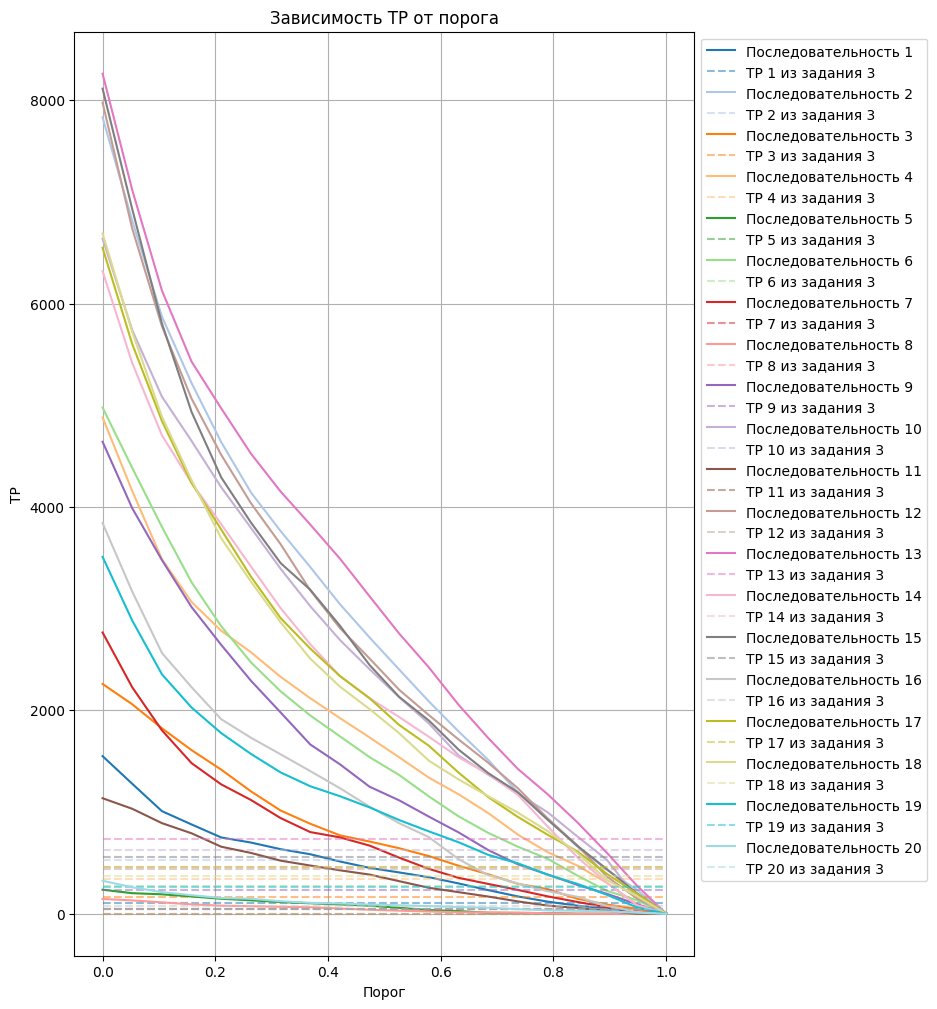

In [110]:
n, i = 20, 0
trhs = np.linspace(0, 1, n)
clrs = plt.get_cmap('tab20', n)
plt.figure(figsize=(8,12))
for nn, ss in seq_libr:
    probl = forward_backward(nn)
    tpv= []    
    for trh in trhs:
        st = state_by_prob(probl, trh)
        tpv.append(tp(ss, st))
    c = clrs(i)
    i += 1
    plt.plot(trhs, tpv, label=f'Последовательность {i}', linestyle='-', color = c)
    plt.plot(trhs, [tps[i-1]]*n, label=f'TP {i} из задания 3', linestyle='--', color = c, alpha=0.5)
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Зависимость TP от порога')
plt.xlabel('Порог')
plt.ylabel('TP')
plt.grid()
plt.show()

**Вывод**: По графику видно, что существуют пороговые значения при которых TP больше чем в задании №3.

От выбранного порогового значения зависит ТР. Чем ниже порог, тем больше ТР. Это объясняется тем, что порог определяет уровень вероятности, при котором состояние считается '+'. Т.е. при 0-ом значении любая вероятность будет приводить к значению '+'. Это повышает TP, но так же приводит к увеличению FP. Поэтому я считаю, что при подборе оптимального порогового значения нужно анализировать разные метрики.